In [18]:
import spacy, scispacy,pickle
import pandas as pd
import matplotlib.pyplot as plt
import re, pprint, string
import seaborn as sns
import numpy as np

In [19]:
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import models, similarities, matutils

In [20]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
import praw
import datetime as dt
import pickle

### Webscraping reddit post from depression subreddit

In [22]:
reddit = praw.Reddit(client_id='0DpPmmvPOod0Pg', \
                     client_secret='JI5HNAxtMNk4f0DZ4OeVpv18uDE', \
                     user_agent='xin', \
                     username='username', \
                     password='password')

In [23]:
subreddit = reddit.subreddit('depression')

In [24]:
top_subreddit = subreddit.top('all', limit = 10000)
topics_dict = { "title":[], \
                "score":[], \
                "id":[], "url":[], \
                "comms_num": [], \
                "created": [], \
                "body":[]}
for submission in top_subreddit:
    topics_dict["title"].append(submission.title)
    topics_dict["score"].append(submission.score)
    topics_dict["id"].append(submission.id)
    topics_dict["url"].append(submission.url)
    topics_dict["comms_num"].append(submission.num_comments)
    topics_dict["created"].append(submission.created)
    topics_dict["body"].append(submission.selftext)

In [25]:
corpus = topics_dict['body']

In [26]:
df = pd.DataFrame(topics_dict)

In [27]:
df

,title,score,id,url,comms_num,created,body
0,Shout out to the particular hell that is funct...,6678,cd0hjp,https://www.reddit.com/r/depression/comments/c...,350,1.563091e+09,"This is me. Don’t get me wrong, it’s better th..."
1,I hate that people don’t understand that i don...,4727,i3ajk8,https://www.reddit.com/r/depression/comments/i...,260,1.596506e+09,
2,If 10 years ago someone told me that in 10 yea...,4418,ccaxvm,https://www.reddit.com/r/depression/comments/c...,218,1.562939e+09,"But here I am, 24 years old man and doing exac..."
3,"It’s like I died at 15, but my body just kept ...",4175,g9ndgw,https://www.reddit.com/r/depression/comments/g...,311,1.588081e+09,I’m trapped inside. Does anyone else get that ...
4,High-functioning depression: I feel like I'm l...,4094,dpl4bu,https://www.reddit.com/r/depression/comments/d...,354,1.572515e+09,I read a lot of posts on here of people strugg...
...,...,...,...,...,...,...,...
964,Today I witnessed the most horrifying moment o...,991,8kybap,https://www.reddit.com/r/depression/comments/8...,125,1.526878e+09,The TV in my house is really old and constantl...
965,Anyone else feel like they go through each day...,992,6ix1lb,https://www.reddit.com/r/depression/comments/6...,79,1.498171e+09,"I'm not sure if that makes sense, but I feel l..."
966,It never gets better,990,rnng8w,https://www.reddit.com/r/depression/comments/r...,272,1.640356e+09,I truly fucking despise every goddamn person i...
967,Depression is physically painful,992,fozmk5,https://www.reddit.com/r/depression/comments/f...,97,1.585175e+09,It literally hurts to live


### Text pre-processing

In [49]:
#Remove punctuations
df.body = df.body.str.replace('[^\w\s]','')

In [48]:
df.body

0      this is me don  t get me wrong it  s better th...
1                                                       
2      but here i am year old man and doing exactly that
3      i  m trapped inside doe anyone else get that f...
4      i read a lot of post on here of people struggl...
                             ...                        
964    the tv in my house is really old and constantl...
965    i m not sure if that make sense but i feel lik...
966    i truly fucking despise every goddamn person i...
967                            it literally hurt to live
968    anyone else instead of sleeping more when depr...
Name: body, Length: 969, dtype: object

In [29]:
#lemmatization
from textblob import TextBlob, Word

def lemma(text):
    sent = TextBlob(text)
    return " ". join([w.lemmatize() for w in sent.words])
df.body = df.body.apply(lemma)

In [30]:
#initialize two vectorizers
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union(['don','ve','ll','wasn','just','feel','like'])

vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern="\\b[a-z][a-z]+\\b", stop_words=stop_words)
tfidf = TfidfVectorizer(ngram_range=(1,2), token_pattern="\\b[a-z][a-z]+\\b", stop_words=stop_words, binary=False)

In [31]:
tfidf.fit(df.body)
dataset = tfidf.transform(df.body).transpose()
pd.DataFrame(dataset.toarray(), tfidf.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,959,960,961,962,963,964,965,966,967,968
abandon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abandon companion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abandoned,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abandoned life,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abandoned sick,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
vectorizer.fit(df.body)
dataset = vectorizer.transform(df.body).transpose()
pd.DataFrame(dataset.toarray(), vectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,959,960,961,962,963,964,965,966,967,968
abandon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandon companion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandoned,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandoned life,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandoned sick,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
corpus = matutils.Sparse2Corpus(dataset)
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [34]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [17]:
lda_model.print_topics()

[(0,
  '0.014*"life" + 0.013*"want" + 0.012*"people" + 0.011*"know" + 0.011*"time" + 0.008*"things" + 0.008*"really" + 0.007*"depression" + 0.007*"going" + 0.006*"day"'),
 (1,
  '0.000*"flowers" + 0.000*"flowers algernon" + 0.000*"charlie flowers" + 0.000*"algernon" + 0.000*"charlie" + 0.000*"literally hurts" + 0.000*"hurts live" + 0.000*"sad actually" + 0.000*"imgur" + 0.000*"imgur com"'),
 (2,
  '0.029*"feeling" + 0.022*"past" + 0.006*"past years" + 0.002*"trapped" + 0.002*"memories" + 0.001*"losing" + 0.000*"circuit" + 0.000*"board" + 0.000*"circuit board" + 0.000*"dated"'),
 (3,
  '0.000*"flowers" + 0.000*"flowers algernon" + 0.000*"charlie flowers" + 0.000*"algernon" + 0.000*"charlie" + 0.000*"literally hurts" + 0.000*"hurts live" + 0.000*"sad actually" + 0.000*"imgur" + 0.000*"imgur com"'),
 (4,
  '0.043*"years" + 0.029*"fuck" + 0.013*"old" + 0.006*"man" + 0.004*"fuck fuck" + 0.002*"exactly" + 0.002*"years old" + 0.000*"new years" + 0.000*"doing stop" + 0.000*"board"'),
 (5,
  '0

word cloud

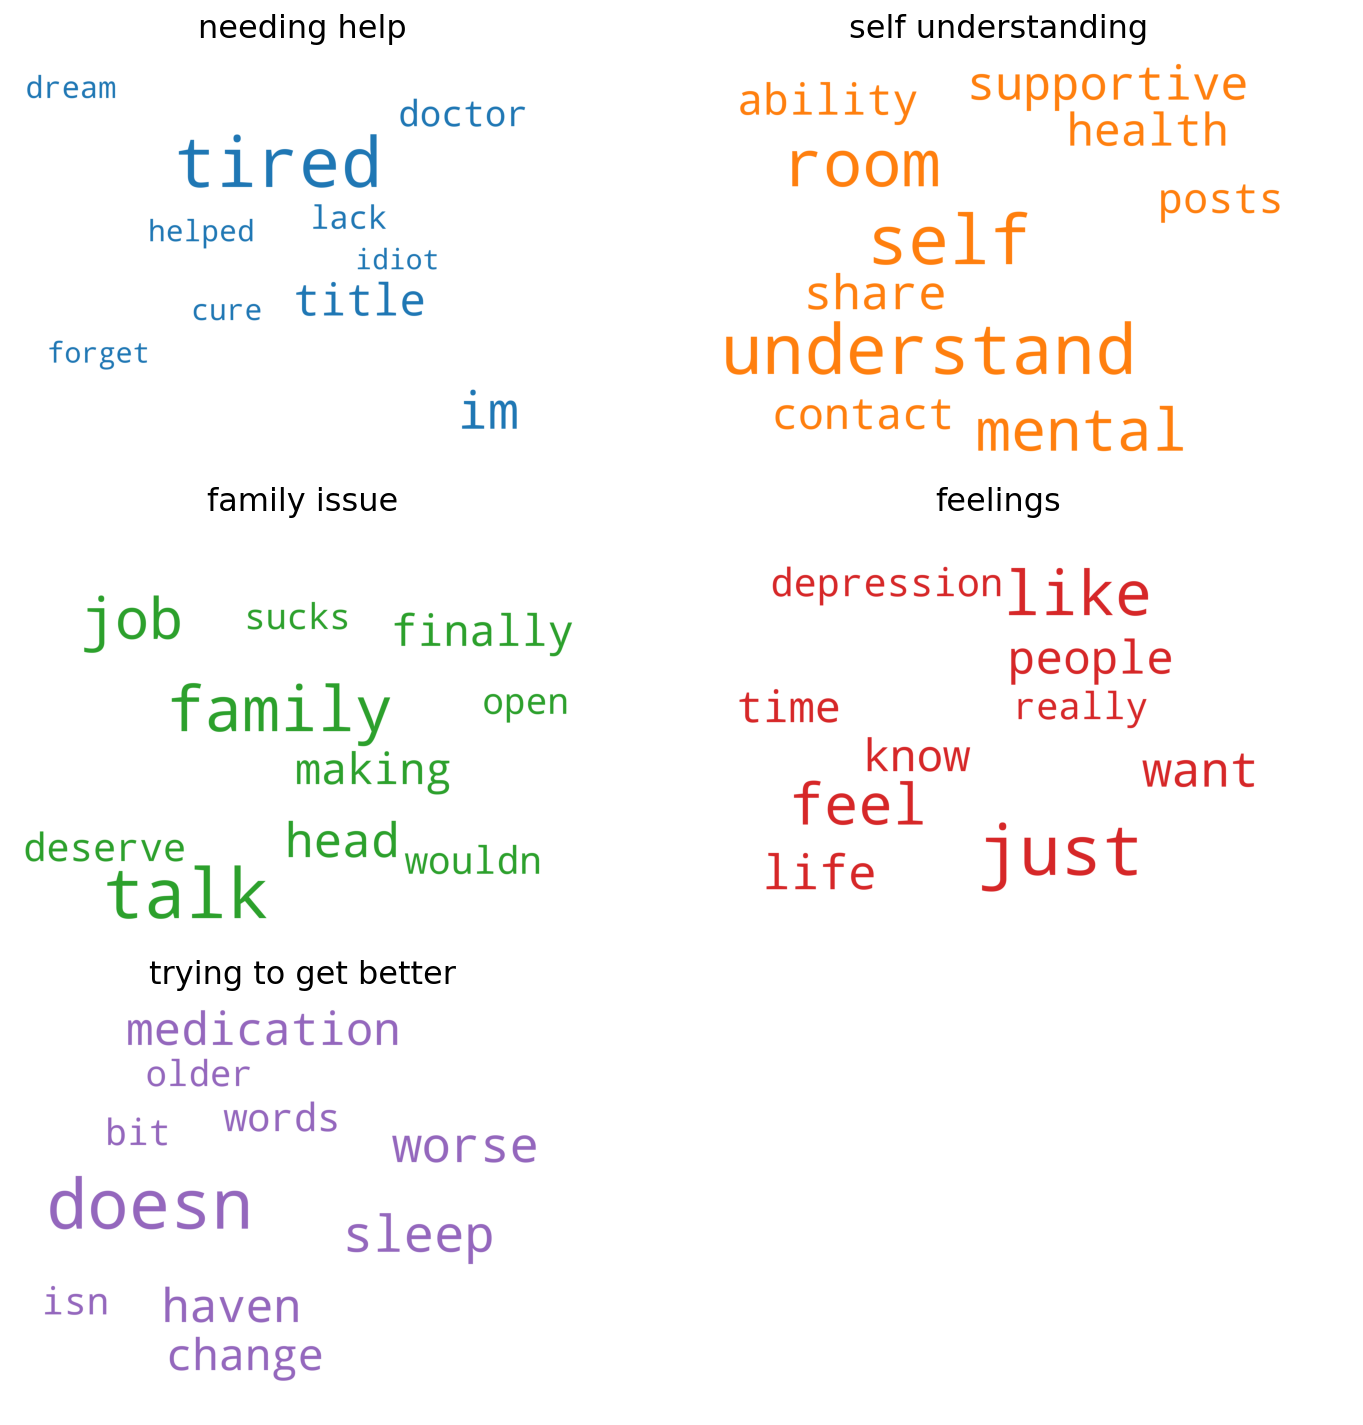

In [134]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)
# axis('off')
topic_ = ['needing help', 'self understanding', 'family issue', 'feelings', 'trying to get better']
for i, ax in enumerate(axes.flatten()):
    if i < 5:
        fig.add_subplot(ax)
        
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title(topic_[i], fontdict=dict(size=16))
        plt.gca().axis('off')
    ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('topic_cloud.jpeg', dpi = 200)
plt.show()



K-means clustering

In [26]:
from sklearn.cluster import MiniBatchKMeans, KMeans

In [149]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [150]:
num_clusters = 5
X = dataset
km = KMeans(n_clusters=num_clusters)
km.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [171]:
km.labels_[km.labels_==3]

array([3, 3, 3, 3, 3, 3], dtype=int32)

In [74]:
list_=[]
for i in range(1,20):
    
    km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    list_.append((i,km.inertia_))

In [75]:
num = []
iner =[]
for i,inter in list_:
    num.append(i)
    iner.append(inter)

In [138]:
#inertia difference
(max(iner) - min(iner))/min(iner)

0.00883140841028638

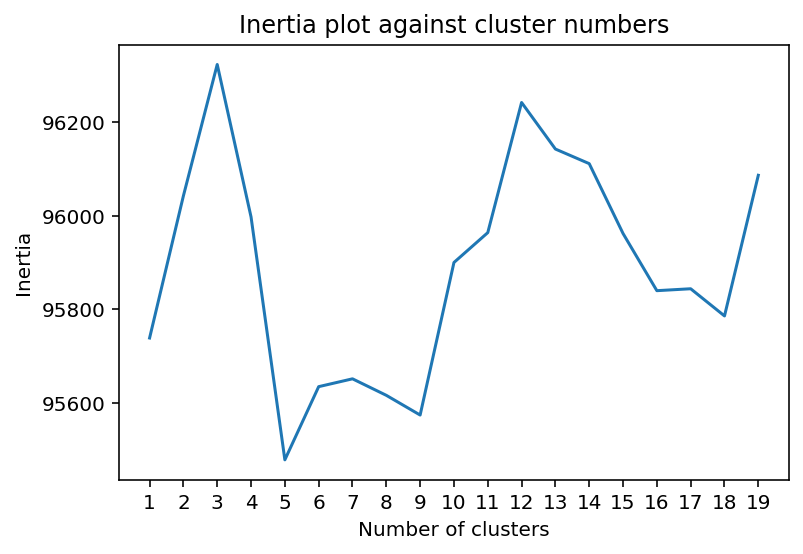

In [131]:
plt.plot(num, iner)
plt.title('Inertia plot against cluster numbers')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(np.arange(1,20))
plt.savefig('inertia_plot.png', dpi = 200)

In [80]:
# reduce the features to 2D
from sklearn.decomposition import PCA
random_state = 0
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(dataset.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(km.cluster_centers_)


In [148]:
pca.components_.shape
# pca.explained_variance_ratio_

(2, 959)

In [78]:
df_reduced_features = pd.DataFrame(reduced_features, columns = ['pca1', 'pca2'])


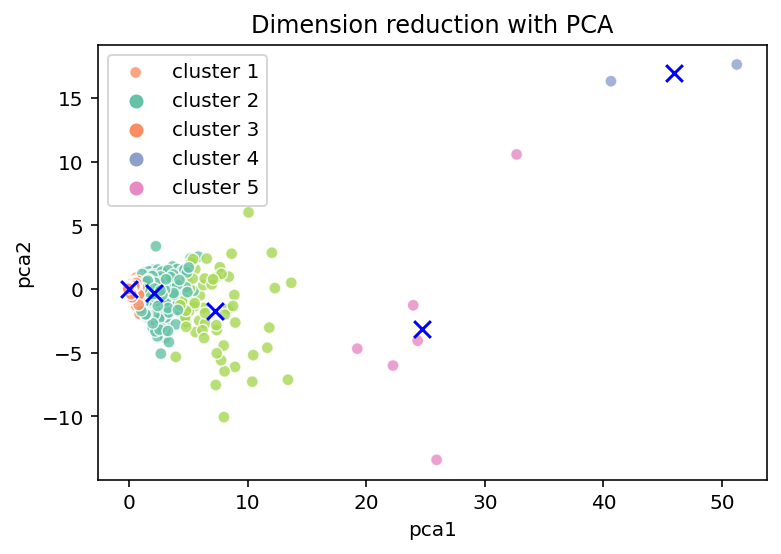

In [82]:

# cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
scatter_plot = sns.scatterplot(x="pca1", y="pca2", hue=km.predict(dataset), data=df_reduced_features, legend='full', palette='Set2', alpha = 0.8)
scatter_plot.set_title('Dimension reduction with PCA')
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=70, c='b')
plt.legend(labels=['cluster 1', 'cluster 2', 'cluster 3','cluster 4','cluster 5'])
plt.savefig('PCA_scatter.png',dpi =300)


In [151]:
from sklearn.metrics import silhouette_score
silhouette_score(dataset, labels=km.predict(dataset))

0.21898600334858884

TSNE visualization

In [132]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

In [153]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

#Get topic names
topic_names = [topic_[i] for i in topic_num]

In [154]:
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 881 samples in 0.001s...
[t-SNE] Computed neighbors for 881 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 881 / 881
[t-SNE] Mean sigma: 0.039073
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.585297
[t-SNE] KL divergence after 1000 iterations: 0.299564


In [172]:



import pandas as pd
import bokeh.plotting as bpl
import bokeh.models as bmo
from bokeh.palettes import d3
bpl.output_notebook()

mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

df_plot = pd.DataFrame(
    {
        'x': tsne_lda[:,0],
        'y': tsne_lda[:,1],
        'color':mycolors[topic_num],
        'label':topic_names
        
    }
)
source = bpl.ColumnDataSource(df_plot)

n_topics = 5
p = bpl.figure(title="t-SNE visualization of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
p.scatter(x='x', y='y',
          color='color',
          legend_group='label', source=source)
bpl.show(p)
# handle = show(p, notebook_handle=True)
# push_notebook(handle=handle)


Loading BokehJS ...